In [1]:
import pandas as pd
import numpy as np
import os
import duckdb
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from statsmodels.stats.weightstats import ztest as ztest

# embeding images
from IPython.display import Image
from IPython.core.display import HTML 

In [2]:
# left-aligning column description table

In [3]:
%%html
<style>
  table {margin-left: 0 !important;}
</style>

# E-Shop Clothing Click Analysis

The data set is from [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/clickstream+data+for+online+shopping#). According to its data set description, *the dataset contains information on clickstream from online store offering clothing for pregnant women. Data are from five months of 2008 and include, among others, product category, location of the photo on the page, country of origin of the IP address and product price in US dollars.* There are 165475 instances in total and each row consists of 14 columns as follows:

| Name | Type | Despcription |
| :-- | :-: | :-- |
| `year` | int | the year of the record: 2008 |
| `month` | int | the month of the record: from April (4) to August (8) | 
| `day` | int | day number of the month |
| `order` | int | sequence of clicks during one session | 
| `country` | int | variable indicating the country of origin of the IP address. <br>  categories are specified in the `e-shop clothing 2008 data description.txt` file in the data directory
| `session ID` | int | variable indicating session id (short record) |
| `page 1 (main category)` | int | indicates the main product category: 1-trousers, 2-skirts, 3-blouses, 4-sale
| `page 2 (clothing model)` | str | contains information about thre code for each product (217 products in total) |
| `colour` | int | color of product <br> 1-beige, 2-black, 3-blue, 4-brown, 5-burgundy, 6-gray, 7-green, 8-navy blue, <br> 9-of many colors, 10-olive, 11-pink, 12-red, 13-violet, 14-white|
| `location` | int | photo location on the page, the screen has been divided into six parts <br> 1-top left, 2-top center, 3-top right 4-bottom left, 5-bottom center, 6-bottom right| 
| `model photography` | int | variable with two categories: 1-en face, 2-profile |
| `price` | int | price in US dollars |
| `price 2` | int | variable informing whether the price of a particular product is higher than the average price for the entire product category <br> 1-yes, 2-no| 
| `page` | int | page number within the e-store website (from 1 to 5) |

## Domain Knowledge

Before diving into analysis, it is important to understand the context of the value of each column and row. The following websites help readers to gain knowledge of this dataset.

- [Difference between sessions and clicks](https://blog.stackadapt.com/sessions-vs-clicks-what-s-the-difference-anyway): Session is each user making certain interactions with your website within a given timeframe while click is an action of users selecting certain elements of the website. In the data set, `session ID` indicates an unique activity of users (possibly the same user) and `order` column represents the sequence of clicks during a specific session. For most cases, there are multiple clicks during a single session.

## Import / Exploratory Data Analysis

Import the data and conduct an exploratory data analysis to get an overall sense of the data set.

Possible questions to answer:

1. How is the amount of traffic distributed across the days of the month?
2. How is the amount of traffic distributed across the countries?
3. Average number of clicks during one session.

In [4]:
# import the data by specifying the separator as ";"
click = pd.read_csv(os.path.join("data", "e-shop clothing 2008.csv"), sep=";")
print(" Row: ", str(click.shape[0]), "\n", "Column: ", str(click.shape[1]))

# printing out first 5 rows of the data
click.head(5)

 Row:  165474 
 Column:  14


,year,month,day,order,country,session ID,page 1 (main category),page 2 (clothing model),colour,location,model photography,price,price 2,page
0,2008,4,1,1,29,1,1,A13,1,5,1,28,2,1
1,2008,4,1,2,29,1,1,A16,1,6,1,33,2,1
2,2008,4,1,3,29,1,2,B4,10,2,1,52,1,1
3,2008,4,1,4,29,1,2,B17,6,6,2,38,2,1
4,2008,4,1,5,29,1,2,B8,4,3,2,52,1,1


In [5]:
# data type of each column
click.dtypes

year                        int64
month                       int64
day                         int64
order                       int64
country                     int64
session ID                  int64
page 1 (main category)      int64
page 2 (clothing model)    object
colour                      int64
location                    int64
model photography           int64
price                       int64
price 2                     int64
page                        int64
dtype: object

### 1. Traffic Distribution Accross the Days of Week

First, create a date column with given year, month, and day columns and extract the weekday for the analysis. Then, count the total number of 1) `clicks` and 2) `sessions` to compare the amount of traffic per weekday.

#### Total Number of Clicks per Weekday

In [6]:
# create weekday column by
# 1. create date columen by combining year, month, and day column
# 2. extract weekday from the newly created date column
temp1 = duckdb.query("""
    SELECT
        CASE
            WHEN dt = 0 THEN 'Sunday'
            WHEN dt = 1 THEN 'Monday'
            WHEN dt = 2 THEN 'Tuesday'
            WHEN dt = 3 THEN 'Wednesday'
            WHEN dt = 4 THEN 'Thursday'
            WHEN dt = 5 THEN 'Friday'
            ELSE 'Saturday'
        END AS day,
        COUNT(*) AS total
    FROM
        (SELECT *, DAYOFWEEK(MAKE_DATE(year, month, day)) AS dt
        FROM click) AS t1
    GROUP BY dt
    ORDER BY dt
""").df()

temp1

,day,total
0,Sunday,18758
1,Monday,25241
2,Tuesday,28697
3,Wednesday,27959
4,Thursday,25356
5,Friday,22684
6,Saturday,16779


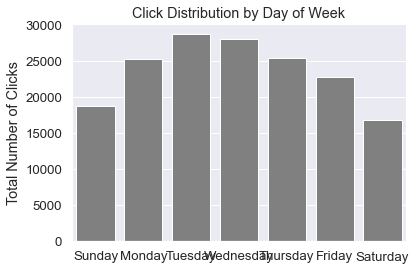

In [7]:
# default setting of the seaborn plot
sns.set_theme()

# specifying the figure size
sns.set(rc={"figure.figsize":(10, 5)}) #width=10, height=5

# increase font size of all elements
sns.set(font_scale=1.2)

# barplot with appropriate labels
p = sns.barplot(x='day', y='total', data=temp1, color='gray')
p.set(xlabel="", ylabel="Total Number of Clicks", title= "Click Distribution by Day of Week")

plt.show()

#### Total Number of Sessions per Weekday

In [8]:
# create weekday column by
# 1. create date columen by combining year, month, and day column
# 2. extract weekday from the newly created date column
# 3. count the number of unique session ID
temp2 = duckdb.query("""
    SELECT
        CASE
            WHEN dt = 0 THEN 'Sunday'
            WHEN dt = 1 THEN 'Monday'
            WHEN dt = 2 THEN 'Tuesday'
            WHEN dt = 3 THEN 'Wednesday'
            WHEN dt = 4 THEN 'Thursday'
            WHEN dt = 5 THEN 'Friday'
            ELSE 'Saturday'
        END AS day,
        COUNT(*) AS total
    FROM
        (SELECT DISTINCT "session ID", DAYOFWEEK(MAKE_DATE(year, month, day)) AS dt
        FROM click) AS t1
    GROUP BY dt
    ORDER BY dt
""").df()

temp2 

,day,total
0,Sunday,2693
1,Monday,3846
2,Tuesday,4287
3,Wednesday,3994
4,Thursday,3530
5,Friday,3293
6,Saturday,2383


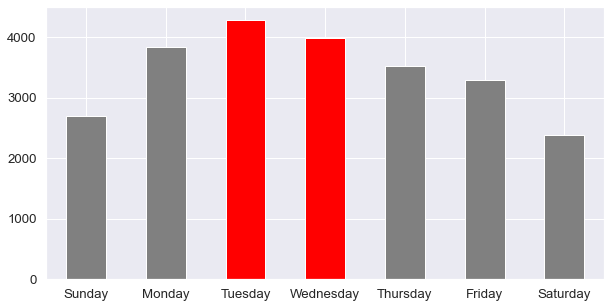

In [9]:
# default setting of the seaborn plot
sns.set_theme()

# specifying the figure size
sns.set(rc={"figure.figsize":(10, 5)}) #width=10, height=5

# increase font size of all elements
sns.set(font_scale=1.2)

# barplot with appropriate labels
a = temp2.total
colors = np.where(a.index.isin([2,3]), 'red', 'gray')
p = temp2.plot(kind="bar", x='day', y='total', color=colors,
        xlabel="", ylabel="", legend=False)
plt.xticks(rotation=0)

plt.show()

Notice the click and session distribution accross the day of week are approximately the same. Saturday has the lowest amount of traffic while Tuesday has the largest amount of traffic for both distributions. It is difficult to find the specific reasons behind this distribution, but we can certainly come up with a hypothesis:

- Recall that this website offers clothings for pregnant women, meaing that the users are most likely pregnant women. Assuming most users are staying at home due to pregnancy, they might have more free time to search for clothings when other family members are not around: weekdays, especially around afternoon.

### 2. Session Distribution Across Countries

Based on the country code specified in `e-shop clothing 2008 data description.txt` file, most of the traffic occured at European countries (mostly Poland).

In [10]:
# group by countries and count the total unqiue sessions
countries = duckdb.query("""
    SELECT CASE
        WHEN country = 29 THEN 'Poland'
        WHEN country = 9  THEN 'Czech Republic'
        WHEN country = 46 THEN '*.net'
        WHEN country = 24 THEN 'Lithuania'
        WHEN country = 44 THEN '*.com'
        WHEN country = 41 THEN 'United Kingdom'
        WHEN country = 21 THEN 'Ireland'
        WHEN country = 16 THEN 'Germany'
        WHEN country = 34 THEN 'Slovakia'
        WHEN country = 12 THEN 'unidentified'
    END AS country
        , COUNT(*) AS total
    FROM
        (SELECT DISTINCT "session ID", country
        FROM click) AS t1
    GROUP BY country
    ORDER BY total DESC
""").df()

countries.head(10)

,country,total
0,Poland,19582
1,Czech Republic,2261
2,*.net,681
3,Lithuania,527
4,*.com,240
5,United Kingdom,127
6,Ireland,102
7,Germany,101
8,Slovakia,88
9,unidentified,28


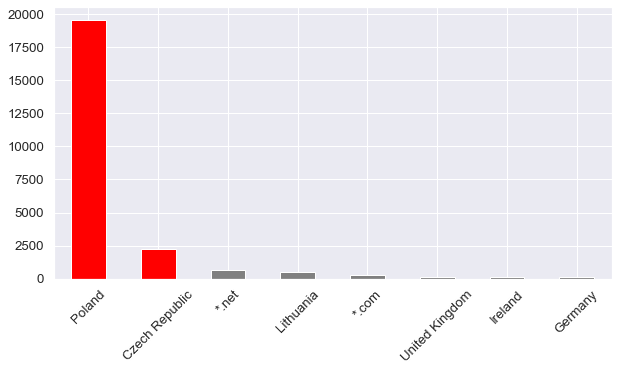

In [11]:
# default setting of the seaborn plot
sns.set_theme()

# specifying the figure size
sns.set(rc={"figure.figsize":(10, 5)}) #width=10, height=5

# increase font size of all elements
sns.set(font_scale=1.2)

# barplot with appropriate labels
a = countries.total
colors = np.where(a.index.isin([0,1]), 'red', 'gray')
p = countries.iloc[0:8, :].plot(kind="bar", x='country', y='total', color=colors,
        xlabel="", ylabel="", legend=False)
plt.xticks(rotation=45)

plt.show()

### 3. Session Distribution Across the Months

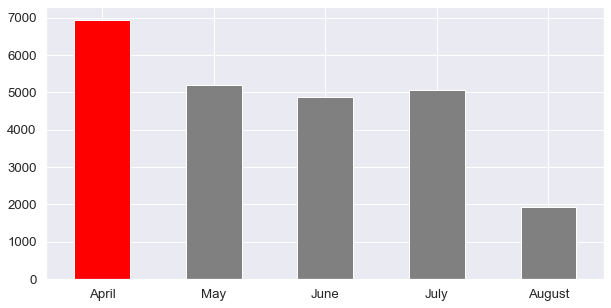

In [12]:
# group by countries and count the total unique sessions
temp3 = duckdb.query("""
    SELECT
        CASE
            WHEN dt = 4 THEN 'April'
            WHEN dt = 5 THEN 'May'
            WHEN dt = 6 THEN 'June'
            WHEN dt = 7 THEN 'July'
            ELSE 'August'
        END AS month,
        COUNT(*) AS total
    FROM
        (SELECT DISTINCT "session ID", month(MAKE_DATE(year, month, day)) AS dt, country
        FROM click) AS t1
    GROUP BY dt
    ORDER BY
        CASE month
            WHEN 'April' THEN 1
            WHEN 'May' THEN 2
            WHEN 'June' THEN 3
            WHEN 'July' THEN 4
            ELSE 5
        END,
        total DESC
""").df()

# plot the dataframe accordingly
a = temp3.total
colors = np.where(a.index == 0, 'red', 'gray')
p = temp3.plot(kind="bar", x='month', y='total', color=colors,
        xlabel="", ylabel="", legend=False)


# setting the rotation of the xlabel as 0 
# turns out the default rotation of the xlabel of seaborn plot object is 90 degree
p.tick_params(axis='x', rotation=0)


Significantly more traffic occurred in April compared to May-August. According to [an article analyzing pregnancy patterns](https://visme.co/blog/most-common-birthday/), there is no country with the highest number of pregnancies in April, and for most European countries, the months with the highest number of pregnancies are from July to October. (In Poland, where website traffic is highest, the month with the highest number of pregnancies is October.)

One hypothesis for the marked decrease in website traffic as August approaches is that, assuming a pregnancy period of about 40 weeks, most births occur around August when pregnancies began in October. If we assume that noticeable changes occur in the pregnant women's body during the 20-22nd week of pregnancy or even earlier and they start looking for maternity clothes, the highest traffic would occur around March-April and the traffic decreases as it approaches August.

### 4. Product Price Distribution

In [13]:
# minimum and maximum product price in US Dollar
duckdb.query("""
    SELECT
        MIN(price) AS min_price,
        MAX(price) AS max_price
    FROM click
""").df()

,min_price,max_price
0,18,82


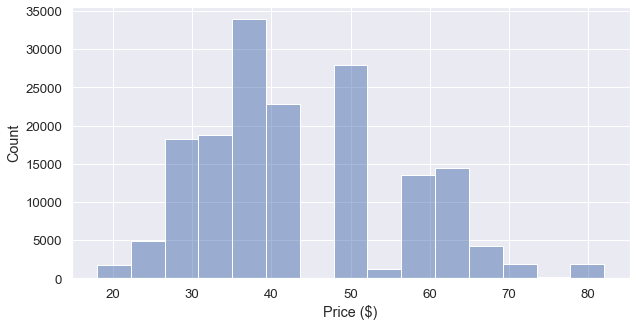

In [14]:
# create a new figure
fig, ax = plt.subplots(figsize=(10,5))

# plot a histogram for price
sns.histplot(ax=ax, data=click[["price"]], bins=15, legend=False)

# set labels
ax.set_xlabel("Price ($)")

plt.show()

---

## Click Analysis

Questions to ask:

1. Does photo location significantly affect the click rate?
2. Is there an interaction effect between photo location and model photography (wheter it is en face or profile)?
3. Is there any significant relationship bewteen product price and clicks?

### Does the photo location significantly affect the click rate?

The `order` columns indicates the sequence of clicks of an user (session ID). Thus, to thoroughly investigate users' behavior in the website, the order of clicks must be taken into consideration rather than naively counting the total number of clicks per photo location. 

**Q. Which photo location is more likely to attract users when they first visit the website? Is it significantly different from others?**

First, consider the first click of each session.

In [15]:
# filter out clicks other than the first one (order = 1)
# then group by photo location to count the total number of first clicks per photo location
temp4 = duckdb.query("""
    SELECT location, COUNT(*) AS first
    FROM click 
    WHERE "order" = 1
    GROUP BY location
    ORDER BY first DESC
""").df()

temp4

# recall:
# 1 - top left
# 2 - top center
# 3 - top roght
# 4 - bottom left
# 5 - bottom center
# 6 - bottom right

,location,first
0,1,6159
1,2,4916
2,5,3963
3,4,3821
4,6,2718
5,3,2449


In [16]:
# perform one sample z-test

ztest(temp4["first"], value=6159)

(-3.8123733923460095, 0.00013763873686633375)

With the p-value of 0.00014, **the photo location of top-left attracts significnatly more users than other locations**. Another interesting point about user behavior is that they prefer left and bottom position of the photo. Notice top-left and top-center have the highest number of users and bottom-center and bottom-left follow. It is less likely for users to click photos located at either bottom-right or top right.

Now, let's consider subsequent clicks.

In [17]:
# create tables for color / photo location / product category
duckdb.query("""
    DROP TABLE IF EXISTS photo_loc;
    CREATE TABLE photo_loc(code INTEGER, loc CHAR);
    
    INSERT INTO photo_loc VALUES (1, 'Top Left');
    INSERT INTO photo_loc VALUES (2, 'Top Center');
    INSERT INTO photo_loc VALUES (3, 'Top Right');
    INSERT INTO photo_loc VALUES (4, 'Bottom Left');
    INSERT INTO photo_loc VALUES (5, 'Bottom Center');
    INSERT INTO photo_loc VALUES (6, 'Bottom Right');
""")

In [18]:
temp5 = duckdb.query("""
    SELECT t2.loc, "order"::CHAR AS "order", COUNT(*) AS total
    FROM
    (
        SELECT *
        FROM click
        WHERE "order" BETWEEN 1 AND 5
    ) AS t1
    LEFT JOIN photo_loc AS t2
    ON t1.location = t2.code
    WHERE page = 1
    GROUP BY t2.loc, "order"
    ORDER BY total DESC
""").df()

temp5.head(5)

,loc,order,total
0,Top Left,1,4963
1,Top Center,1,3800
2,Bottom Left,1,3083
3,Bottom Center,1,2923
4,Top Left,2,2893


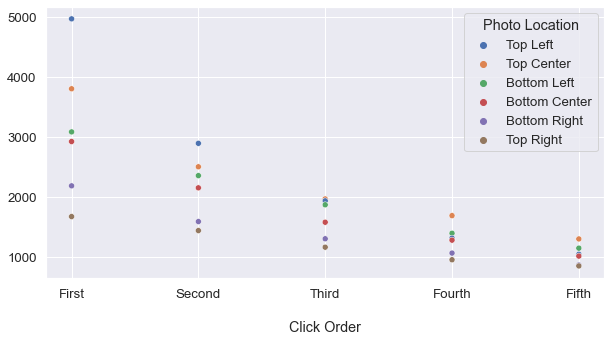

In [19]:
# create a new figure
fig, ax = plt.subplots(figsize=(10,5))

# plot a scatter plot for each order of click
sns.scatterplot(ax=ax, data=temp5, x="order", y="total", hue="loc")
ax.legend(title="Photo Location")

# setting labels properly
ax.set_xlabel("Click Order")
ax.set_ylabel("")

# manually change x tick labels from numeric code to the actual photo location
# first, set the location of x ticks and change the x labels appropriately
ax.set_xticks(range(0, 5), labels=["First", "Second", "Third", "Fourth", "Fifth"])
# move xaxis label further down
ax.xaxis.labelpad = 20

plt.show()

Notice top-left has the largest amount of traffic for most cases, while the top-right has the least amount of traffic. While the first click has the most traffic, its deviation among photo locations is larger compared to that of other click orders. As customers make more subsequent clicks, they tend to not care about photo location as much.

### Is there an interaction effect between photo location and model photography?

Let's only consider the first click users make.

In [20]:
temp6 = duckdb.query("""
    SELECT location, COUNT(*) AS total,
        CASE
            WHEN "model photography" = 1 THEN 'en face'
            ELSE 'profile'
        END AS "model photography"
    FROM
        (
            SELECT *
            FROM click
            WHERE "order" = 1
                AND ("model photography" = 1 OR "model photography" = 2)
                AND page = 1
        ) AS t1
    GROUP BY location, "model photography"
""").df()

temp6

,location,total,model photography
0,4,2915,en face
1,2,2923,en face
2,1,4313,en face
3,6,1817,en face
4,3,1323,en face
5,5,1511,en face
6,1,650,profile
7,5,1412,profile
8,3,352,profile
9,2,877,profile


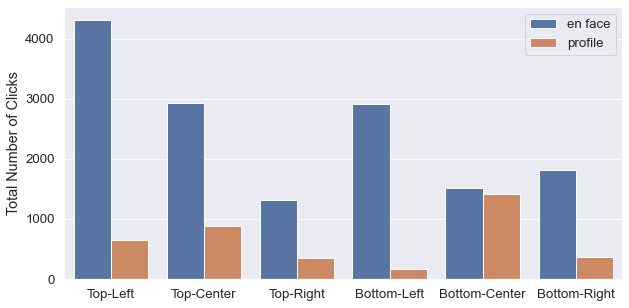

In [21]:
# create a new figure
fig, ax = plt.subplots(figsize=(10,5))

# plot a scatter plot for each order of click
sns.barplot(ax=ax, data=temp6, x="location", y="total", hue="model photography")

# # set the labels
ax.set_xlabel("")
ax.set_ylabel("Total Number of Clicks")

# manually change x tick labels from numeric code to the actual photo location
# first, set the location of x ticks and change the x labels appropriately
ax.set_xticks(range(6), labels=["Top-Left", "Top-Center", "Top-Right", "Bottom-Left", "Bottom-Center", "Bottom-Right"])

# update legend position
plt.legend(loc='upper right')

plt.show()

Due to the huge overall difference in traffic between en face and profile photo types, it is difficult to draw any statistical conclusion. However, there are still a few points to which pay close attention.

1. Top-left photo location has the largest traffic discrepancy between the two photo types.
2. Bottom-center has the least traffic difference between the two photo types.
3. While the amount of traffic fluctuates among top-right, bottom-left, and bottom-right for en face type, it does not differ that much for profile photo type.

### Any Significant Relationship bewteen Product Price and Clicks?

Recall that `1` indicates 'Yes' (product price higher than the average price in its category) and `2` indicates 'No' (product price lower than the average price in its category).

In [22]:
# among the first clicks, what is the percentage of each `price 2` column value?
duckdb.query("""
    SELECT
        CASE
            WHEN "price 2" = 1 THEN 'Yes'
            ELSE 'No'
        END AS "price 2",
        total / SUM(total) OVER()::DECIMAL * 100 AS percentage 
    FROM (
        SELECT "price 2", COUNT(*) AS total
        FROM click
        WHERE "order" = 1
        GROUP BY "price 2") AS t1
    ORDER BY percentage DESC
""").df()

,price 2,percentage
0,Yes,50.48281
1,No,49.51719


Customers are slightly more likely (~1%) to click on a particular product if the price of the product is higher than the average price for the other products in the same category. Although the difference is trivial, the result is a bit counterintuitive: customers click more for expensive products. One should be careful about drawing such a conclusion since there are other interacted factors such as color, product type, clothing model, etc.

Now, only consider sessions making more than 1 click for subsequent click analysis: **given first click's `price 2` value, what are the percentage of each `price 2` columne value for the next click?**

1. Filter out sessions with less than 2 clicks.
2. Of selected sessions, filter out rows whose `price 2` column value is not 1 (not 2 - for the second analysis).
3. Calculate percentage of each `price 2` value.

Given the first click's `price 2` value is 'Yes', the percentage for each `price 2` column value is as follows:

In [23]:
duckdb.query("""
    WITH temp1 AS
    (
        SELECT "session ID", "order", "price 2"
        FROM (
            SELECT *,
                COUNT(*) OVER(PARTITION BY "session ID") AS total
            FROM click
            WHERE "order" = 1 OR "order" = 2
            ORDER BY "session ID") AS t1
        WHERE total = 2
    ),
    
    temp2 AS
    (   
        SELECT *
        FROM temp1
        WHERE "order" = 1 AND "price 2" = 1
    ),
    
    temp3 AS
    (
        -- Only select sessions whose first click 'price 2' column value is 1
        SELECT *
        FROM temp1
        WHERE "session ID" IN (SELECT "session ID" FROM temp2)
        ORDER BY "session ID", "order"
    )
    
    SELECT
        CASE
            WHEN "price 2" = 1 THEN 'Yes'
            ELSE 'No'
        END AS "price 2",
        total / SUM(total) OVER()::DECIMAL * 100 AS percentage
    FROM (
        SELECT
            "price 2",
            COUNT(*) AS total
        FROM temp3
        WHERE "order" = 2
        GROUP BY "price 2"
        ) AS t1
    
""").df()

,price 2,percentage
0,Yes,56.018081
1,No,43.981919


Without taking into account other factors, customers who made first click on the products with a higher price compared to the average price of other products in the same catgory are more likely (~12%) to click on products that are ALSO more expensive than the average price.

Now, repeat this analysis for rows whose first click `price 2` value is 2 (No).

In [24]:
duckdb.query("""
    WITH temp1 AS
    (
        SELECT "session ID", "order", "price 2"
        FROM (
            SELECT *,
                COUNT(*) OVER(PARTITION BY "session ID") AS total
            FROM click
            WHERE "order" = 1 OR "order" = 2
            ORDER BY "session ID") AS t1
        WHERE total = 2
    ),
    
    temp2 AS
    (   
        SELECT *
        FROM temp1
        WHERE "order" = 1 AND "price 2" = 2
    ),
    
    temp3 AS
    (
        -- Only select sessions whose first click 'price 2' column value is 2
        SELECT *
        FROM temp1
        WHERE "session ID" IN (SELECT "session ID" FROM temp2)
        ORDER BY "session ID", "order"
    )
    
    SELECT
        CASE
            WHEN "price 2" = 1 THEN 'Yes'
            ELSE 'No'
        END AS "price 2",
        total / SUM(total) OVER()::DECIMAL * 100 AS percentage
    FROM (
        SELECT
            "price 2",
            COUNT(*) AS total
        FROM temp3
        WHERE "order" = 2
        GROUP BY "price 2"
        ) AS t1
    
""").df()

,price 2,percentage
0,No,55.052265
1,Yes,44.947735


Customers who made the first click on the product that are cheaper than the average price of its category are much more likely (~11%) to make second clicks on the products that are cheaper as well.

### What is the popular product type, color, or type-color combination?

Let's only consider the **first** click customers make when they entered the website.

In [25]:
# create tables for color / product category
duckdb.query("""
    DROP TABLE IF EXISTS color;
    CREATE TABLE color(code INTEGER, color CHAR);
    
    INSERT INTO color VALUES (1, 'beige');
    INSERT INTO color VALUES (2, 'black');
    INSERT INTO color VALUES (3, 'blue');
    INSERT INTO color VALUES (4, 'brown');
    INSERT INTO color VALUES (5, 'burgundy');
    INSERT INTO color VALUES (6, 'gray');
    INSERT INTO color VALUES (7, 'green');
    INSERT INTO color VALUES (8, 'navy blue');
    INSERT INTO color VALUES (9, 'of many colors');
    INSERT INTO color VALUES (10, 'olive');
    INSERT INTO color VALUES (11, 'pink');
    INSERT INTO color VALUES (12, 'red');
    INSERT INTO color VALUES (13, 'violet');
    INSERT INTO color VALUES (14, 'white');
""")

duckdb.query("""
    DROP TABLE IF EXISTS category;
    CREATE TABLE category(code INTEGER, type CHAR);
    
    INSERT INTO category VALUES (1, 'trousers');
    INSERT INTO category VALUES (2, 'skirts');
    INSERT INTO category VALUES (3, 'blouses');
    INSERT INTO category VALUES (4, 'sale');
""")

In [26]:
# total number of clicks per color
duckdb.query("""
    SELECT t2.color, COUNT(*) AS total
    FROM click AS t1
    LEFT JOIN color AS t2
    ON t1.colour = t2.code
    WHERE "order" = 1 AND page = 1
    GROUP BY t2.color
    ORDER BY total DESC
""").df().head()

,color,total
0,blue,5700
1,black,3040
2,brown,1970
3,navy blue,1231
4,red,1141


Without considering other factors, blue has significantly more clicks compared to other product colors. Let's consider the photo location this time.

In [27]:
# number of the first clicks on the first page for each color product and photo location
temp7 = duckdb.query("""
    SELECT color, loc, total
    FROM
    (
        SELECT colour, location, COUNT(*) AS total
        FROM click
        WHERE page = 1 AND "order" = 1
        GROUP BY colour, location
        ORDER BY total DESC
    ) AS t1
    LEFT JOIN color AS t2
    ON t1.colour = t2.code
    LEFT JOIN photo_loc AS t3
    ON t1.location = t3.code
    ORDER BY total DESC
""").df()

temp7.head(5)

,color,loc,total
0,blue,Top Left,2235
1,blue,Top Center,1596
2,black,Bottom Left,1508
3,navy blue,Top Left,1231
4,blue,Bottom Left,1027


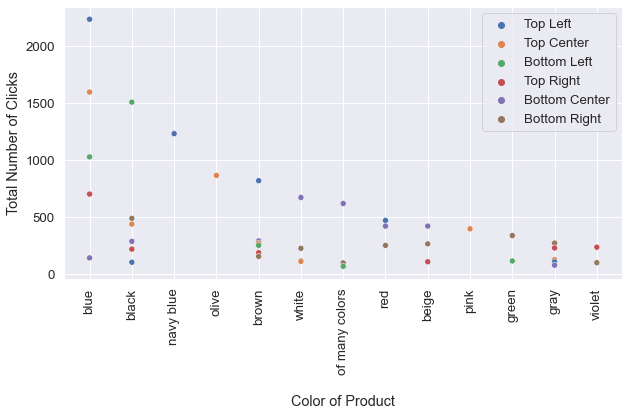

In [28]:
# create a new figure
fig, ax = plt.subplots(figsize=(10,5))

# plot a scatter plot for each order of click
sns.scatterplot(ax=ax, data=temp7, x="color", y="total", hue="loc")

# # set the labels
ax.set_xlabel("Color of Product")
ax.set_ylabel("Total Number of Clicks")

# move xaxis label further down
ax.xaxis.labelpad = 20

# rotate x label 
ax.tick_params(axis="x", rotation=90)

# update legend position
plt.legend(loc='upper right')

plt.show()

Blue products located at the top left on the first page of the website have the highest number of first clicks. Now let's consider product type as well.

In [29]:
temp8 = duckdb.query("""
    SELECT color, type, total
    FROM
    (
        SELECT colour, "page 1 (main category)" AS category, COUNT(*) AS total
        FROM click
        WHERE page = 1 AND "order" = 1
        GROUP BY colour, category
        ORDER BY total DESC
    ) AS t1
    LEFT JOIN color AS t2
    ON t1.colour = t2.code
    LEFT JOIN category AS t3
    ON t1.category = t3.code
    ORDER BY total DESC
""").df()

temp8.head()

,color,type,total
0,blue,trousers,4535
1,black,skirts,1529
2,navy blue,trousers,1231
3,blue,sale,943
4,red,skirts,917


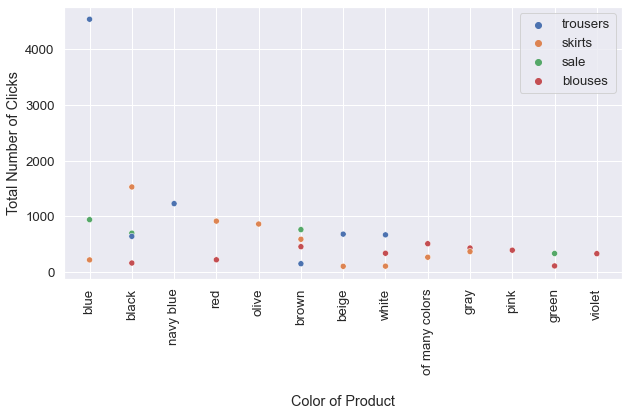

In [30]:
# create a new figure
fig, ax = plt.subplots(figsize=(10,5))

# plot a scatter plot for each order of click
sns.scatterplot(ax=ax, data=temp8, x="color", y="total", hue="type")

# # set the labels
ax.set_xlabel("Color of Product")
ax.set_ylabel("Total Number of Clicks")

# move xaxis label further down
ax.xaxis.labelpad = 20

# rotate x label 
ax.tick_params(axis="x", rotation=90)

# update legend position
plt.legend(loc='upper right')

plt.show()

Among all possible color-category combinations, the blue trouser has significantly more clicks than others on the first page. Keep in mind this is only the first response analysis: the first click a customer makes on the first page of the website.

## Category-Location Combination

In [31]:
cate_loc_df = duckdb.query("""
    SELECT
        loc
        , type
        , COUNT(*) AS total
    FROM
    (
        SELECT *
        FROM click AS t1
        LEFT JOIN photo_loc AS t2
        ON t1.location = t2.code
        LEFT JOIN category AS t3
        ON t1."page 1 (main category)" = t3.code
    )
    WHERE "order" = 1 AND page = 1
    GROUP BY loc, type
    ORDER BY total DESC
""").df()

cate_loc_df.head()

,loc,type,total
0,Top Left,trousers,2391
1,Top Center,trousers,1506
2,Bottom Left,trousers,1327
3,Bottom Center,trousers,1232
4,Bottom Left,skirts,1208


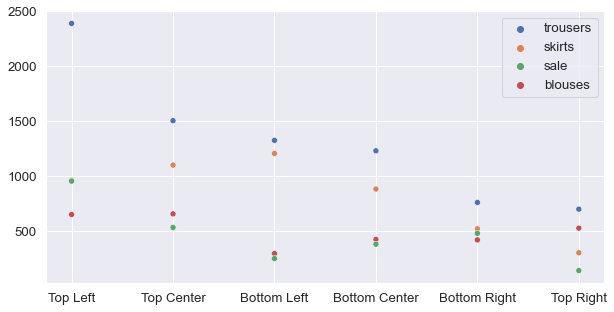

In [32]:
# create a new figure
fig, ax = plt.subplots(figsize=(10,5))

# plot a scatter plot for each order of click
sns.scatterplot(ax=ax, data=cate_loc_df, x="loc", y="total", hue="type")

# # set the labels
ax.set_xlabel("")
ax.set_ylabel("")

# move xaxis label further down
ax.xaxis.labelpad = 20

# rotate x label 
ax.tick_params(axis="x", rotation=0)

# update legend position
plt.legend(loc='upper right')

plt.show()